In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.stats import qmc

In [2]:
import fusionrate
from fusionrate import Reaction

In [3]:
C_SCALE = 1e-16

In [4]:
def generate_profile(rho, x0, alpha_x):
    """This function generates radial based parabolic profiles 
    for densities / temperatures , 0<rho<1
    
    args
    ----------
    - rho (array-like): radial position
    - n0 (float): denisity at rho =0 
    - alpha_x (int): exponential values 1-3 
    
    returns
    ----------
    - profile (array-like): an array of radial based profiles (temp or density)
    
    """
    profile = x0 * ((1 - (rho**2))**alpha_x)
    
    return profile 

In [5]:
def volume_averaged_density(densities, volumes):
    """This function finds the volume averaged density 
    
    Parms:
        - densisties (array-like): an array of densities of each partition
        - volumes (array-like): an array of volumes of each parition
        
    Returns:
        - vol_avg_density (float): density averaged over the whole volume
    """

    
    vol_avg_density = (np.sum(np.multiply(densities,volumes)))/(np.sum(volumes))
    
    return vol_avg_density

In [6]:
def volume_averaged_temperature(densities, volumes, temperatures):
    """This function finds the volume averaged temperature 
    
    Params: 
        - densities(array-like): an array of densities of each partition
        - volumes(array-like): an array of volumes of each parition
        - temperature(array-like): an array of temperatures of each partition 

    Returns: 
        - vol_avg_temperature (float): temperature averaged over the whole volume 
    
    """
    
    
    vol_avg_temperature = (np.sum(np.multiply(temperatures,(np.multiply(densities,volumes))))/(np.sum(np.multiply(densities,volumes))))
    type(vol_avg_temperature)
    
    return vol_avg_temperature

In [7]:
def generate_volumes(rho, a, R):
    '''This function creates an array of volume elements of equal temperature and density
    
    args
    ------
    rho (array-like): array of radii 
    a (float): minor radius of torus
    R (float): major radius of torus 
    
    return
    -------
    volumes (array-like): array of volume elements 
    
    '''
    drho = 1/len(rho) #the change in rho is the amount of lengths (1/100th in this case)
    
    
    #initialzing
    total_area = 0 
    
    volumes = []
    
    for i in rho: #indexing elements of array rho
        ring_area = (a**2) * i * drho * 2*math.pi 
        ring_volume = ring_area *2*math.pi * R
        volumes.append(ring_volume)
        
    return volumes

In [8]:
def compute_highfidelityFR(n0, alpha_n, T0, alpha_T, a, R):
    '''This function computes the high-fidelity fusion rate 
    
    args
    ------
    - n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (array-like)
    - T0: initial temperature, estimate around 10 Kev (array-like)
    - alpha_T: exponential (array-like)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    
    returns
    --------
    - highfidelityFR: high-fidelity fusion rate (float)
    
    '''
    
    
    rho = np.linspace(0,1,num=100)

    densities = generate_profile(rho,n0,alpha_n)
    
    temperatures = generate_profile(rho,T0,alpha_T)
        
    volumes = generate_volumes(rho,a,R)
    
    dt = Reaction('D+T')
    rate_coeff = dt.rate_coefficient(temperatures, scheme = 'analytic')

    
    sectionalHFFR = (np.multiply(rate_coeff,np.multiply(densities,densities))) 
    
    
    highfidelityFR=sum(np.multiply(sectionalHFFR,volumes))
    

    return highfidelityFR


In [9]:
compute_highfidelityFR(10**20, 2, 10, 2, 1, 10)

2.0934780824985033e+25

In [10]:
def compute_highfidelityFR_deriv(n0, alpha_n, T0, alpha_T, a, R):
    '''This function computes the derivative of the high-fidelity fusion rate with respect to temperature
    
    args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (array-like)
    - T0: initial temperature, estimate around 10 Kev (array-like)
    - alpha_T: exponential (array-like)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    
    returns
    --------
    - highfidelityFR_deriv: derivative of high fidelity fusion rate (float)

    '''
    
    
    rho = np.linspace(0,1,num=100)

    densities = generate_profile(rho,n0,alpha_n)
    
    temperatures = generate_profile(rho,T0,alpha_T)
    
    volumes = generate_volumes(rho,a,R)
    
    dt = Reaction("D+T")
    rate_coeff_deriv = dt.rate_coefficient(temperatures, scheme ='analytic',derivatives=True)
    
    sectionalHFFR_deriv = (np.multiply(rate_coeff_deriv,np.multiply(densities,densities)))
    
    highfidelityFR_deriv=sum(np.multiply(sectionalHFFR_deriv,volumes))
    
    
    return highfidelityFR_deriv

In [11]:
compute_highfidelityFR_deriv(10**20, 2, 10, 2, 1, 10)

7.27676445988046e+24

In [12]:
def generate_lowfidelityFR(n0, alpha_n, log_T0, alpha_T, a, R):
    '''This function generates parameters necessary for computation of the low-fidelity FR model
   
   args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (array-like)
    - log_T0: initial temperature, estimate around 10 Kev (array-like) in logspace
    - alpha_T: exponential (array-like)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    
    returns
    --------
    - c: compute best guess from formula (float)
    - B: best guess around 2 (float)
    '''
    rho = np.linspace(0,1,num=100)
    
    T0=np.exp(log_T0)#change T0 into linear space 
    
    highfidelityFR = compute_highfidelityFR(n0, alpha_n, T0, alpha_T, a, R)
    highfidelityFR_deriv = compute_highfidelityFR_deriv(n0, alpha_n, T0, alpha_T, a, R)
    
    densities = generate_profile(rho,n0,alpha_n)
    temperatures = generate_profile(rho,T0,alpha_T)
    volumes = generate_volumes(rho,a,R)
    
    total_volume = sum(volumes)
    
    vol_avg_density = volume_averaged_density(densities, volumes)
    vol_avg_temperature = volume_averaged_temperature(densities, volumes, temperatures)
    
    def f1(c,B):
        return total_volume * c * vol_avg_density**2 *vol_avg_temperature**B - highfidelityFR / C_SCALE
    
    def f2(c,B):
        return total_volume * c * vol_avg_density**2 * B * vol_avg_temperature**(B-1) - highfidelityFR_deriv / C_SCALE
    
    def f(c,B):
        return f1(c,B), f2(c,B)
    
    def wrapper_of_f_for_fsolve(x):
        return np.array(f(*x))
    
    c_sol = scipy.optimize.fsolve(wrapper_of_f_for_fsolve, [1,2], xtol=1e-2)
    fofcsol = f(*c_sol)
    
   
    return c_sol


In [13]:
c_sol = generate_lowfidelityFR(10**20, 2, 10, 2, 1, 10)

c = c_sol[0]
B = c_sol[1]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [14]:
def compute_lowfidelityFR(n0, alpha_n, T0, alpha_T, a, R, c, B):
    """This function computes the low-fidelity fusion rate
    
    args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (array-like)
    - T0: initial temperature, estimate around 10 Kev (array-like)
    - alpha_T: exponential (array-like)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    - c: (float)
    - B: (float)
    
    returns
    --------
    - lowfidelityFR: low-fidelity fusion rate (float)
    
    """
    rho = np.linspace(0,1,num=100)
    
   
    
    densities = generate_profile(rho,n0,alpha_n)
    temperatures = generate_profile(rho,T0,alpha_T)
    volumes = generate_volumes(rho,a,R)
    
    total_volume = sum(volumes)
    
    vol_avg_density = volume_averaged_density(densities, volumes)
    vol_avg_temperature = volume_averaged_temperature(densities, volumes, temperatures)
    
    
    lowfidelityFR = total_volume * C_SCALE * c * vol_avg_density**2 *vol_avg_temperature**B
    
    return lowfidelityFR
    
    

In [15]:
compute_lowfidelityFR(10**20, 2, 10, 2, 1, 10, c= c_sol[0], B= c_sol[1])

1.5415684522375593e+22

In [16]:
def compute_lowfidelityFR_deriv(n0, alpha_n, T0, alpha_T, a, R, c, B):
    """This function computes the derivative of the high-fidelity fusion rate with respect to temperature
    
     args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (int)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (int)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    - c: (float)
    - B: (float)
    
    returns
    ---------
    -lowfidelityFR_deriv: derivative of low-fidelity fusion rate (float)
    
    """
    rho = np.linspace(0,1,num=100)
    
    
    
    densities = generate_profile(rho,n0,alpha_n)
    temperatures = generate_profile(rho,T0,alpha_T)
    volumes = generate_volumes(rho,a,R)
    
    total_volume = sum(volumes)
    
    vol_avg_density = volume_averaged_density(densities, volumes)
    vol_avg_temperature = volume_averaged_temperature(densities, volumes, temperatures)
    

    
    lowfidelityFR_deriv = total_volume * C_SCALE * c * vol_avg_density**2 * B * vol_avg_temperature**(B-1)
    
    return lowfidelityFR_deriv
    
    
    

In [17]:
compute_lowfidelityFR_deriv(10**20, 2, 10, 2, 1, 10, c=c_sol[0], B=c_sol[1])

-1.1752444044023811e+21

Create initial set of points to train low-fidelity models with initial range of about 50 points
Choose interesting input ranges
alpha_n (1,5)
alpha_T (1,5)
T0 (1,100)

Start by picking points at random, can develop more sophisticated Sobol Sequence or something 

Questions 
- now we must pass list of points through my function instead of individual integers
- should n0, a, R have a range or is that constant? 

In [18]:
def generate_halton_sequence(n, ranges):
    """
    This function generates the training points for data over interesting ranges
    
    Arguments:
    - n: The number of points to generate.
    - ranges: A list of tuples specifying the range for each dimension.
    
    Returns:
    A list of tuples representing the generated points in the Halton sequence.
    """
    num_dimensions = len(ranges)
    low = np.array([min_value for min_value, _ in ranges])
    high = np.array([max_value for _, max_value in ranges])
    halton = qmc.Halton(num_dimensions)
    scaled_points = halton.random(n)
    scaled_points = low + scaled_points * (high - low)
    sequence = [tuple(point) for point in scaled_points]
    
    return sequence

n = 3 #number of training points 
ranges = [(1,5), (1,5), (np.log(1),np.log(100))] #ranges for alpha_n, alpha_T, and T0 in log space
sequence = generate_halton_sequence(n, ranges) #generating training data 

#changing sequence to an array 
sequence = np.array(sequence)


print(sequence)   

[[4.35732751 2.05324875 1.36937708]
 [2.35732751 4.71991541 0.44834305]
 [3.35732751 3.38658208 4.1324792 ]]


In [19]:
#Gaussian Process Regressor 



for row in sequence:
    alpha_n, alpha_T, log_T0 = row
    
#x is a 3D array (points_alpha_T, points_alpha_n, points_t0)
X =  sequence #Not sure what the correct method of passing all these points in is


#y is a 2D array, C and B, outputs of generate low_fidelity function for input training points 
y = [generate_lowfidelityFR(10**20, row[0], row[2], row[1], 1, 10) for row in sequence]

# y1 is c values and y2 is B values    
y1,y2 = np.array(y).T

print(y1)

print(y2)

[2.89323494e-03 9.90029980e-04 3.92055439e+00]
[3.29176384 2.69201636 0.44359522]


In [20]:
#Gaussian process model for y1 (c)

#defining the kernel 
kernelc = ConstantKernel(constant_value=1.0,constant_value_bounds=(1e-2,1e2)) * RBF(length_scale=1, length_scale_bounds=(1e-2,20))   
    
#create a GPR model - use default kernel - not sure about n_restarts
gprc = GaussianProcessRegressor(kernel=kernelc, n_restarts_optimizer=9)

#fit model to data
gprc.fit(X, np.log(y1))

#generate points in inputspace to predict 
x_pred = np.linspace(0,5,100)

#predict function values for input points & standard deviation 
y1_pred, y1_std = gprc.predict(sequence, return_std = True)

In [21]:
#(np.exp(y1_std) * C_SCALE)
print(y1_pred,y1_std)

[-5.84538005 -6.91777533  1.36623307] [9.99991160e-06 9.99991160e-06 1.00000892e-05]


In [22]:
#Gaussian process model for y2 (B)

kernelB = ConstantKernel(constant_value=1.0,constant_value_bounds=(.1,10)) * RBF(length_scale=0.5, length_scale_bounds=(0.1,20))   
    
#create a GPR model - use default kernel - not sure about n_restarts
gprB = GaussianProcessRegressor(kernel=kernelB, n_restarts_optimizer=9)

#fit model to data
gprB.fit(X,y2)

#generate points in inputspace to predict 
x_pred = np.linspace(0,5,100)

#predict function values for input points & standard deviation 
y2_pred, y2_std = gprB.predict(sequence, return_std = True)

In [23]:
print(y2_pred,y2_std)

[3.29176384 2.69201636 0.44359522] [9.99991160e-06 1.00000004e-05 1.00000004e-05]


In [24]:
n_grid = 200 #sets number of points in each grid to 200

alpha_n_test = np.linspace(1,5, num =n_grid) #200 points between 1 and 5
alpha_T_test = np.linspace(1,5,num =n_grid) #200 points between 1 and 5 
#lower = np.log(1)
#upper = np.log(100)
T0_test=np.geomspace(1,100,num =n_grid) #logarithmically spaced values 
#T0_test=np.linspace(math.log(1),math.log(100),num =n_grid)

alpha_T_grid, T0_grid = np.meshgrid(alpha_T_test, T0_test) #creates a grid of points from alpha_T_test and T0 test
alpha_n_grid = np.ones_like(alpha_T_grid)*2.0 #array filled with 2s


In [25]:
#y1_std = np.exp(y1_std)
#y2_std = np.exp(y2_std)

In [26]:
#T0_grid= np.exp(T0_grid)

In [27]:
print(T0_grid)

[[  1.           1.           1.         ...   1.           1.
    1.        ]
 [  1.0234114    1.0234114    1.0234114  ...   1.0234114    1.0234114
    1.0234114 ]
 [  1.0473709    1.0473709    1.0473709  ...   1.0473709    1.0473709
    1.0473709 ]
 ...
 [ 95.47716114  95.47716114  95.47716114 ...  95.47716114  95.47716114
   95.47716114]
 [ 97.71241535  97.71241535  97.71241535 ...  97.71241535  97.71241535
   97.71241535]
 [100.         100.         100.         ... 100.         100.
  100.        ]]


In [28]:
#reshapes 3 grids into an array "test_points"
test_points = np.reshape(np.array([alpha_T_grid,alpha_n_grid, (np.log(T0_grid))]),(3,n_grid*n_grid)).T

In [29]:
y1_pred, y1_std = gprc.predict(test_points, return_std = True)
y1_pred = np.reshape(y1_pred,(n_grid,n_grid))
y1_std = np.reshape(y1_std,(n_grid,n_grid))

Text(0, 0.5, 'c Prediction')

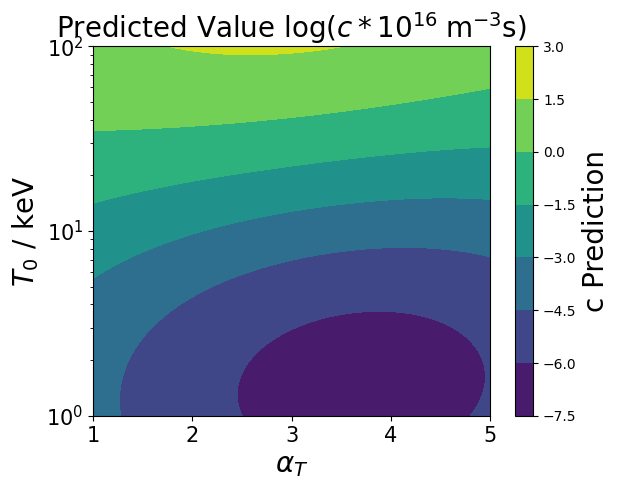

In [30]:
fig1, ax = plt.subplots()
ax.set_yscale('log')
plt.xlabel(r"$\alpha_T$", size = 20)
plt.ylabel(r"$T_0$ / keV", size = 20)
CS = ax.contourf(alpha_T_grid, T0_grid, y1_pred)
#ax.clabel(CS, inline= True, fontsize = 10)
plt.axis([1,5,1,100])
ax.set_title('Predicted Value ' + r'$\log(c * 10^{16} \; \mathrm{m}^{-3}\mathrm{s})$', size = 20)

ax.tick_params(axis='both', which='major', labelsize=15)

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('c Prediction', size = 20)

Text(0, 0.5, 'c STD')

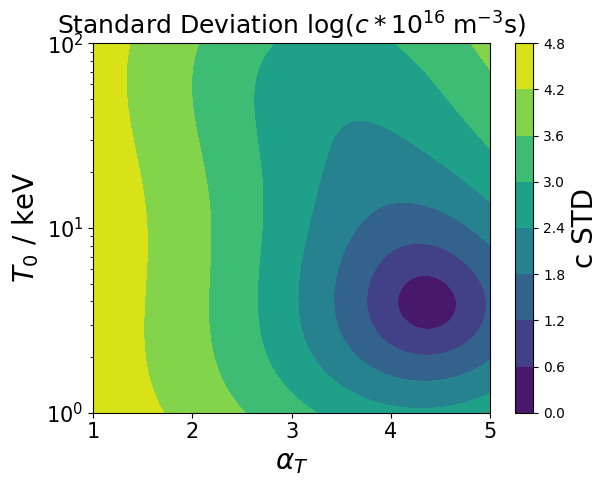

In [31]:
fig2, ax = plt.subplots()
ax.set_yscale('log')
plt.xlabel(r"$\alpha_T$", size = 20)
plt.ylabel(r"$T_0$ / keV", size = 20)
CS = ax.contourf(alpha_T_grid, T0_grid, y1_std)

#ax.clabel(CS, inline= True, fontsize = 8)
plt.axis([1,5,1,100])
ax.set_title('Standard Deviation ' + r'$\log(c * 10^{16} \; \mathrm{m}^{-3}\mathrm{s})$', size = 18)

ax.tick_params(axis='both', which='major', labelsize=15)

cbar = fig2.colorbar(CS)
cbar.ax.set_ylabel('c STD', size = 20)

In [32]:
y2_pred, y2_std = gprB.predict(test_points, return_std = True)
y2_pred = np.reshape(y2_pred,(n_grid,n_grid))
y2_std = np.reshape(y2_std,(n_grid,n_grid))

Text(0, 0.5, '$\\beta%$ Prediction')

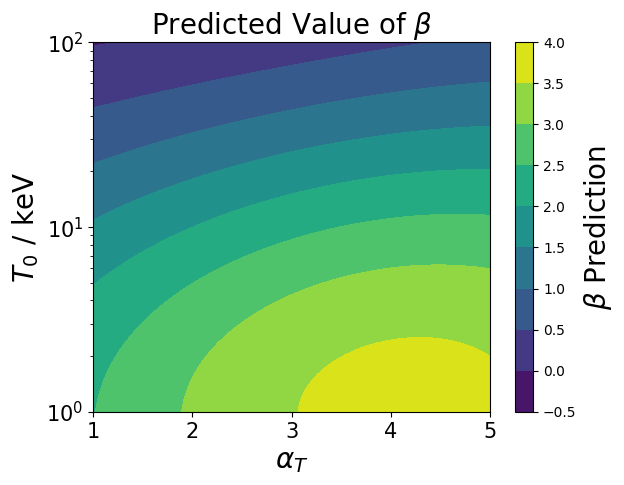

In [33]:
fig3, ax = plt.subplots()
ax.set_yscale('log')
plt.xlabel(r"$\alpha_T$", size = 20)
plt.ylabel(r"$T_0$ / keV", size = 20)
CS = ax.contourf(alpha_T_grid, T0_grid, y2_pred)
#ax.clabel(CS, inline= True, fontsize = 10)
plt.axis([1,5,1,100])
ax.set_title('Predicted Value of ' + r'$\beta%$', size = 20)

ax.tick_params(axis='both', which='major', labelsize=15)

cbar = fig3.colorbar(CS)
cbar.ax.set_ylabel(r'$\beta%$'+' Prediction', size = 20)


Text(0, 0.5, '$\\beta%$ STD')

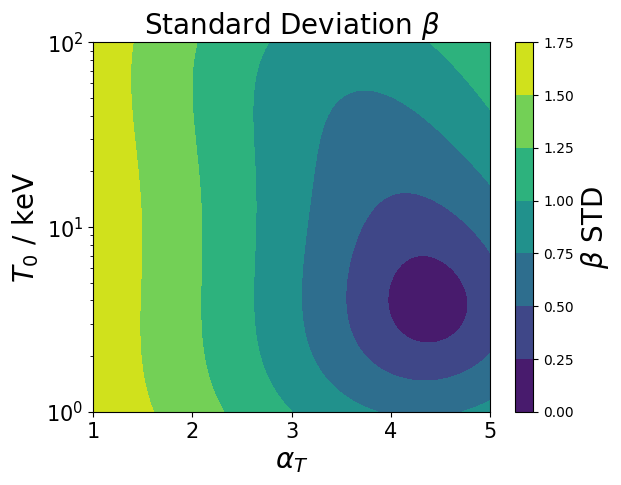

In [34]:
fig4, ax = plt.subplots()
ax.set_yscale('log')
plt.xlabel(r"$\alpha_T$", size = 20)
plt.ylabel(r"$T_0$ / keV", size = 20)
CS = ax.contourf(alpha_T_grid, T0_grid, y2_std)
#ax.clabel(CS, inline= True, fontsize = 10)
plt.axis([1,5,1,100])
ax.set_title('Standard Deviation '+r'$\beta%$', size = 20)

ax.tick_params(axis='both', which='major', labelsize=15)

cbar = fig4.colorbar(CS)
cbar.ax.set_ylabel(r'$\beta%$'+ ' STD', size = 20)